# Chlorophyll vs Control

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

# input file

In [3]:
#### print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

 GNG595


What year? (year)


 20yrclim


In [4]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [5]:
newNCDFfiles = sorted(glob.glob('/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim/*', recursive=True),
                      key=numericalSort)

In [6]:
new = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [11]:
new.T

<xarray.DataArray 'T_FLUX_EXCH_INTRF' (time: 12, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(12, 384, 320), dtype=float32, chunksize=(1, 384, 320)>
Coordinates:
  * time     (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Vertical Temperature Flux Across Upper/Lower Layer Interfa...
    units:         degC*cm/s
    grid_loc:      2110
    cell_methods:  time: mean

In [7]:
obsfiles = sorted(glob.glob('/glade/work/jluo/obs/SeaWiFS/climatology_regridded/'+'*L3m_MC_CHL_chl_ocx_gx1v6.nc', recursive=True),
                      key=numericalSort)
obs = xr.open_mfdataset(obsfiles,combine='by_coords')

In [8]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [9]:
chla_new = np.nansum(np.stack([new.ppChl, new.mp1Chl, new.diazChl, new.diat1Chl, new.mp2Chl, new.diat2Chl, new.mp3Chl, new.diat3Chl, new.mp4Chl]), axis =0)
chla_new[chla_new<=0]=np.nan

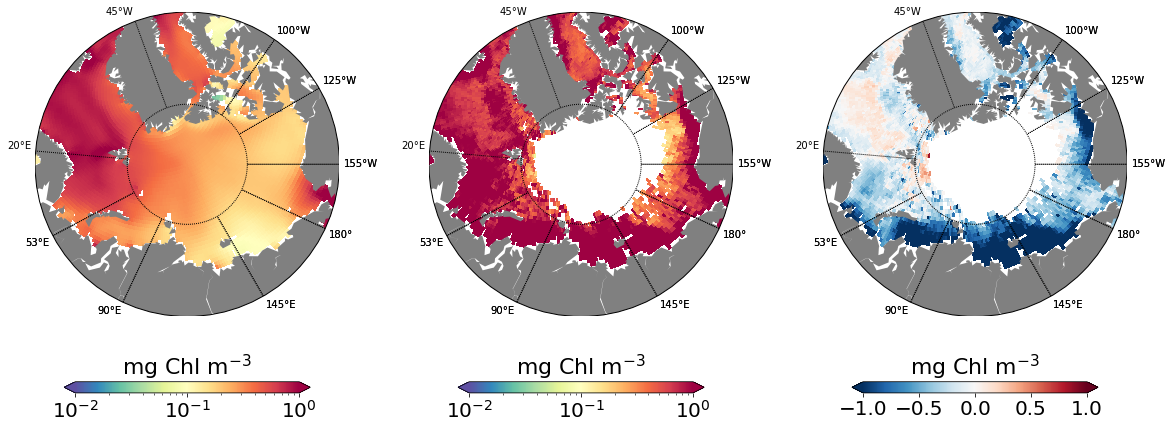

In [11]:
fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chl = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(chla_new[2:9,0,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg$ $Chl$ $m^{-3}$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
#ax.set_title('SPECTRA Chlorophyll', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,260), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((260,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
tlon, tlat, chlo = adjust_pop_grid(new.TLONG, new.TLAT, np.nanmean(obs.chl_ocx[:,:,:], axis=0))
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chlo,cmap='Spectral_r', norm=colors.LogNorm(vmin=0.01, vmax=1))
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg$ $Chl$ $m^{-3}$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
#ax.set_title('SeaWIFS Chlorophyll', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,260), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((260,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,(np.log10(chl)-np.log10(chlo)),cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('$mg$ $Chl$ $m^{-3}$', fontsize = 22)
cb.ax.tick_params(labelsize=20)
#ax.set_title('SPECTRA - SeaWIFS', fontsize =20)

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,260), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((260,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0])
#fig.text(0.05, 0.98, 'a',fontsize=24, fontweight='bold')
#fig.text(0.3, 0.98, 'b',fontsize=24, fontweight='bold')
#fig.text(0.55, 0.98, 'c',fontsize=24, fontweight='bold')

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chla_AO_annual_comparison'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

## Seasonality in both SPECTRA and SeaWIFS throughout the Arctic

In [11]:
obsfiles_regrid = sorted(glob.glob('/glade/scratch/gabyn/SeaWiFS/regrid_chl_ocx_SeaWiFS.*.nc', recursive=True),
                      key=numericalSort)
obss = xr.open_mfdataset(obsfiles_regrid,concat_dim='time',combine='nested')

In [12]:
diat1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat1Chl.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,combine='by_coords')

diat2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat2Chl.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,combine='by_coords')

diat3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat3Chl.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,combine='by_coords')

mp1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp1Chl.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,combine='by_coords')

mp2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp2Chl.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,combine='by_coords')

mp3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp3Chl.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,combine='by_coords')

mp4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp4Chl.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,combine='by_coords')

pp_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_ppChl.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,combine='by_coords')

diaz_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diazChl.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,combine='by_coords')

In [13]:
phytoChl = np.stack([pp_ds.ppChl, mp1_ds.mp1Chl, diaz_ds.diazChl, 
                               diat1_ds.diat1Chl, mp2_ds.mp2Chl, diat2_ds.diat2Chl, 
                               mp3_ds.mp3Chl, diat3_ds.diat3Chl, mp4_ds.mp4Chl])

phytoChl = np.nansum(phytoChl, axis =(0,2))

In [ ]:
phytoChl.shape

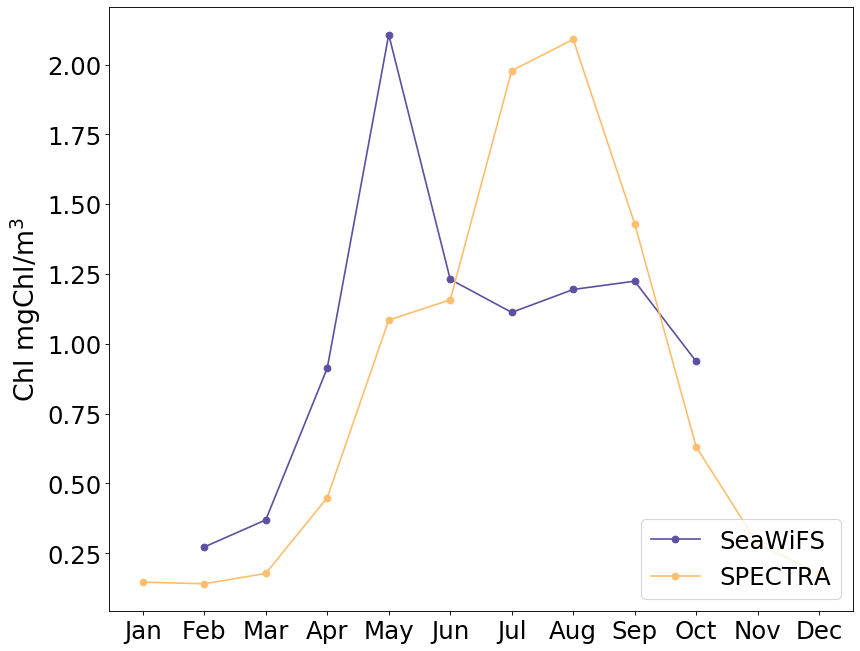

In [17]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,np.nanmean(obss.chl_ocx[:,150:189, :],axis=(1,2)), '-o', color=cmap(9),label='SeaWiFS')
pylab.plot(months,np.nanmean(phytoChl[:,150:189, :], axis=(1,2)), '-o', color=cmap(3),label='SPECTRA')

pylab.legend(loc='lower right', fontsize=22)
#pylab.ylim([0,1])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_global_motnhly'+year+'year.png', dpi=600, bbox_inches='tight')

In [14]:
# Model Chlorophyll for every region 
model_ao = np.nanmean(phytoChl[:,170:180,:], axis=(1,2))
model_cs = np.nanmean(phytoChl[:,149:170,0:25], axis = (1,2))
model_bs = np.nanmean(phytoChl[:,149:170,25:55], axis = (1,2))
model_ca = np.nanmean(phytoChl[:,149:170,55:110], axis = (1,2))
model_bb = np.nanmean(phytoChl[:,149:170,110:135], axis = (1,2))
model_ess = np.nanmean(phytoChl[:,149:170,325:360], axis = (1,2))
model_ls = np.nanmean(phytoChl[:,149:170,270:325], axis = (1,2))
model_ns = np.nanmean(phytoChl[:,149:170,155:205], axis = (1,2))
model_bts =np.nanmean(phytoChl[:,149:170,205:233], axis = (1,2))
model_ks = np.nanmean(phytoChl[:,149:170,233:270], axis = (1,2))

# Observed Chlorophyll for every region. 

obs_ao = np.nanmean(obss.chl_ocx[:,170:180,:], axis=(1,2))
obs_cs = np.nanmean(obss.chl_ocx[:,149:170,0:25], axis = (1,2))
obs_bs = np.nanmean(obss.chl_ocx[:,149:170,25:55], axis = (1,2))
obs_ca = np.nanmean(obss.chl_ocx[:,149:170,55:110], axis = (1,2))
obs_bb = np.nanmean(obss.chl_ocx[:,149:170,110:135], axis = (1,2))
obs_ess = np.nanmean(obss.chl_ocx[:,149:170,325:360], axis = (1,2))
obs_ls = np.nanmean(obss.chl_ocx[:,149:170,270:325], axis = (1,2))
obs_ns = np.nanmean(obss.chl_ocx[:,149:170,155:205], axis = (1,2))
obs_bts =np.nanmean(obss.chl_ocx[:,149:170,205:233], axis = (1,2))
obs_ks = np.nanmean(obss.chl_ocx[:,149:170,233:270], axis = (1,2))

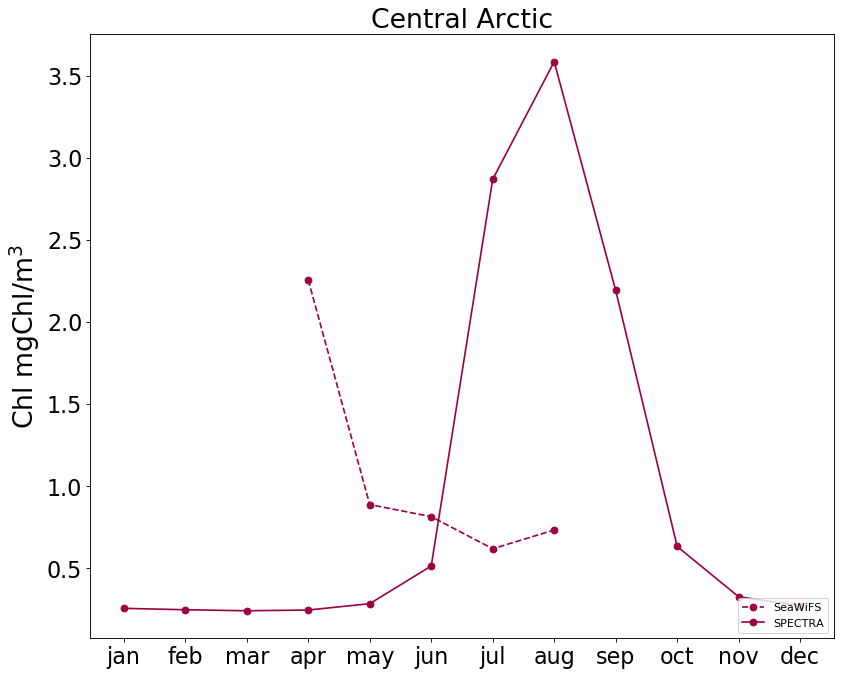

In [19]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ao, '--o', color=cmap(0),label='SeaWiFS')
pylab.plot(months,model_ao, '-o', color=cmap(0),label='SPECTRA')


pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Central Arctic', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_central_Arctic_'+year+'year.png', dpi=600, bbox_inches='tight')

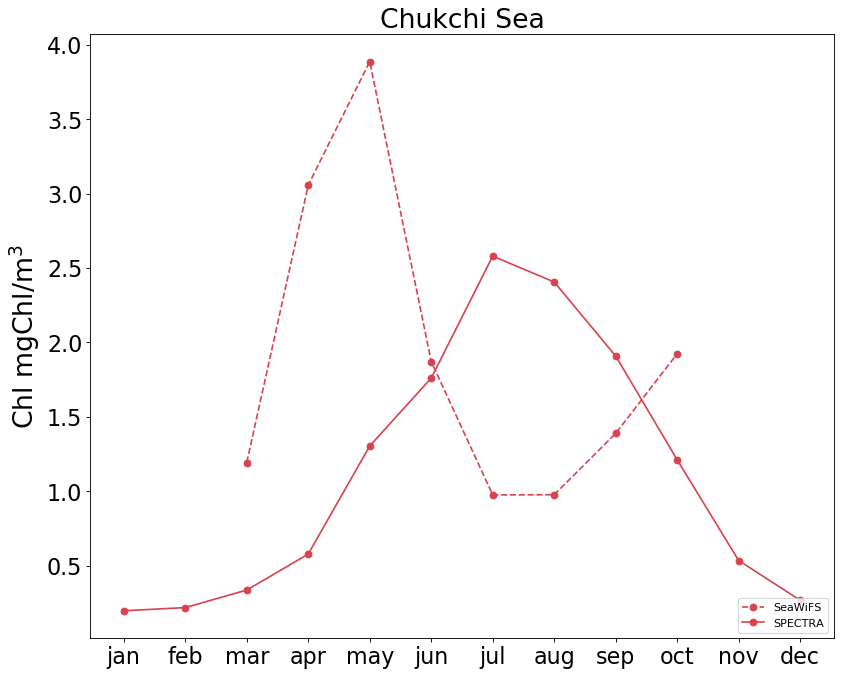

In [20]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_cs, '--o',color=cmap(1),label='SeaWiFS')
pylab.plot(months,model_cs, '-o',color=cmap(1),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Chukchi Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Chukchi_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

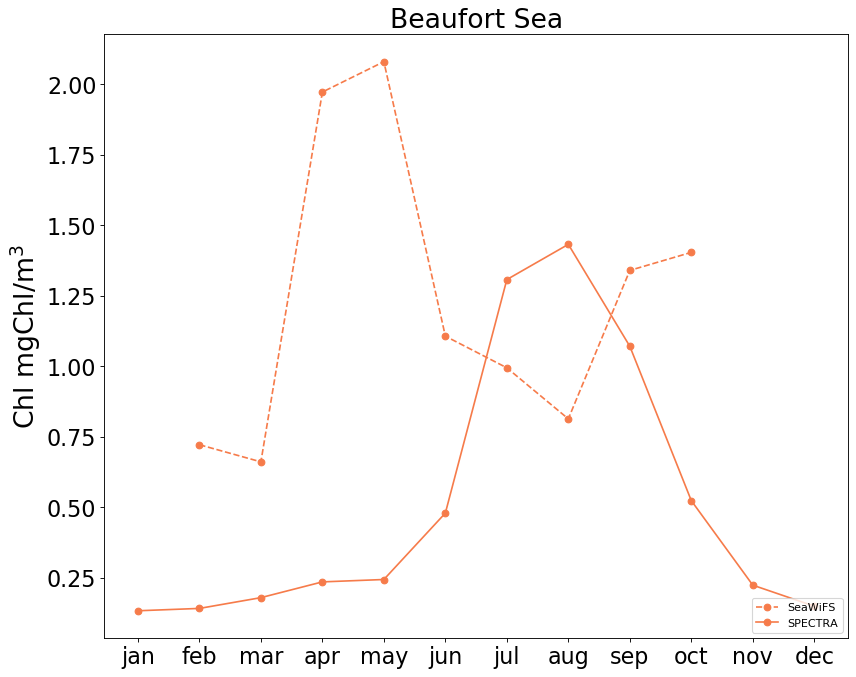

In [21]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_bs, '--o', color=cmap(2),label='SeaWiFS')
pylab.plot(months,model_bs, '-o', color=cmap(2),label='SPECTRA')


pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Beaufort Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Beaufort_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

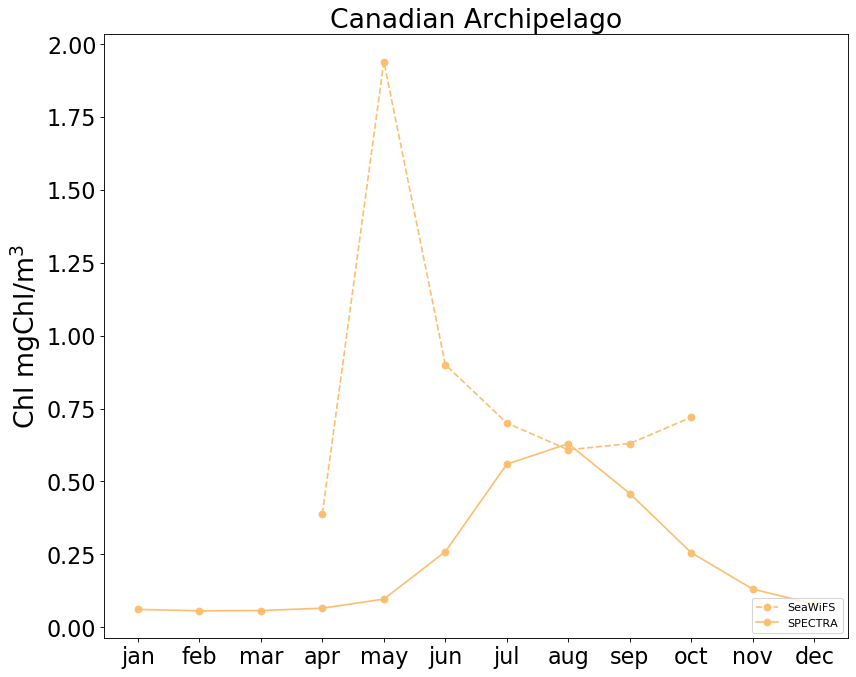

In [22]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ca, '--o', color=cmap(3),label='SeaWiFS')
pylab.plot(months,model_ca, '-o', color=cmap(3),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Canadian Archipelago', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Canadian_Archipelago_'+year+'year.png', dpi=600, bbox_inches='tight')

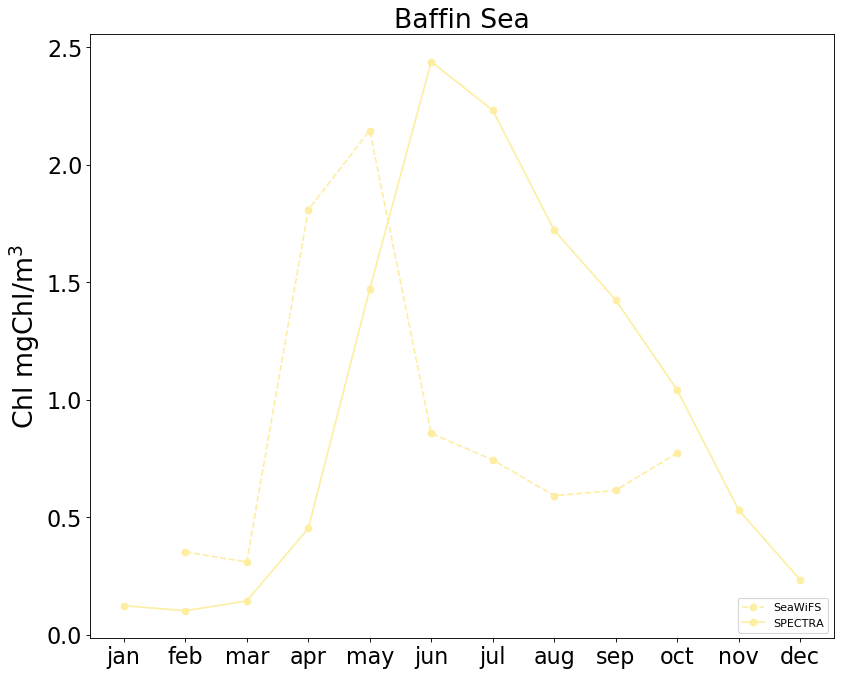

In [23]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_bb, '--o', color=cmap(4),label='SeaWiFS')
pylab.plot(months,model_bb, '-o', color=cmap(4),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Baffin Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Baffin_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

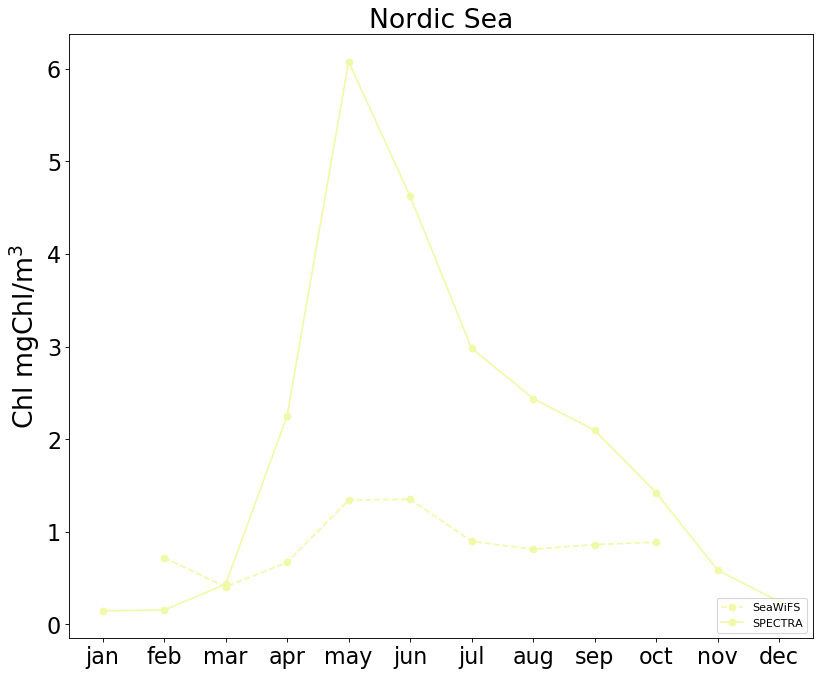

In [24]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ns, '--o', color=cmap(5),label='SeaWiFS')
pylab.plot(months,model_ns, '-o', color=cmap(5),label='SPECTRA')


pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Nordic Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Nordic_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

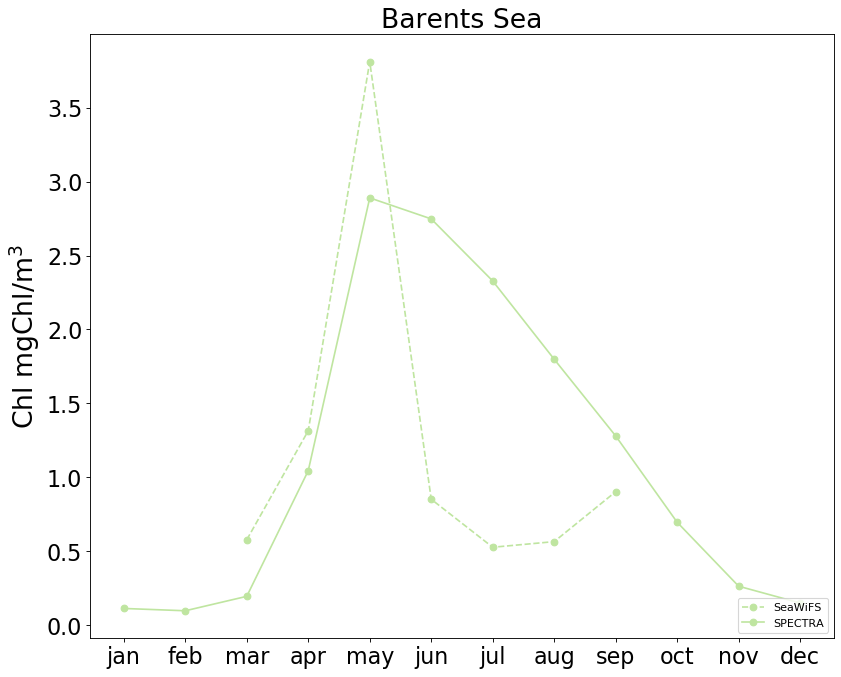

In [25]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_bts, '--o',color=cmap(6),label='SeaWiFS')
pylab.plot(months,model_bts, '-o',color=cmap(6),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Barents Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Barents_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

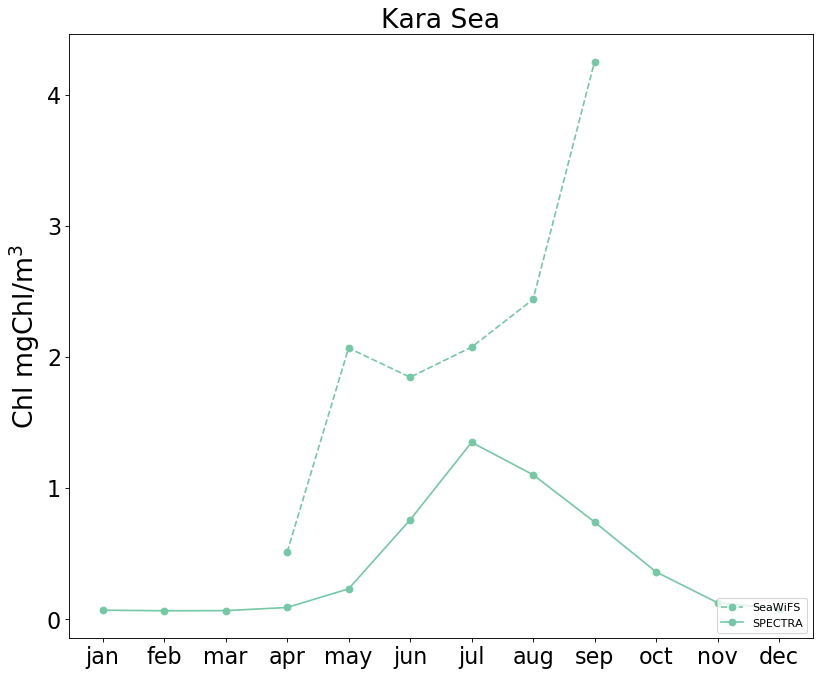

In [26]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ks, '--o', color=cmap(7),label='SeaWiFS')
pylab.plot(months,model_ks, '-o', color=cmap(7),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Kara Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Kara_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

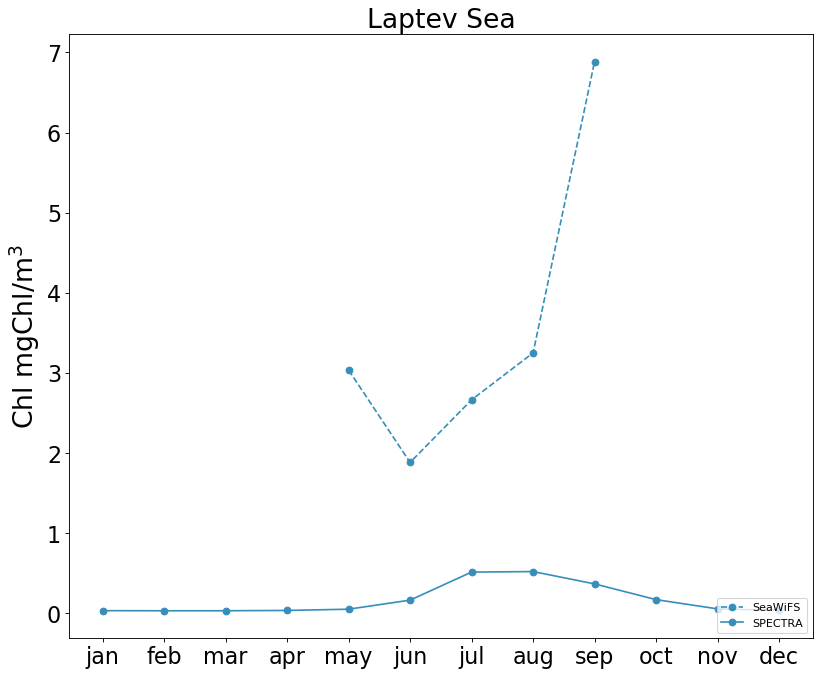

In [27]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ls, '--o', color=cmap(8),label='SeaWiFS')
pylab.plot(months,model_ls, '-o', color=cmap(8),label='SPECTRA')


pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Laptev Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_Laptev_Sea_'+year+'year.png', dpi=600, bbox_inches='tight')

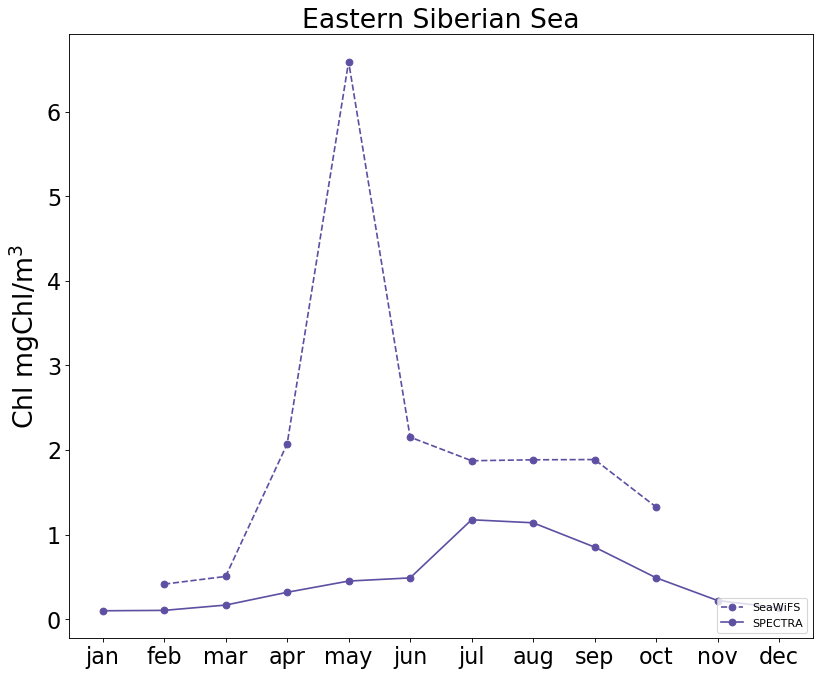

In [28]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(months,obs_ess, '--o', color=cmap(9),label='SeaWiFS')
pylab.plot(months,model_ess, '-o', color=cmap(9),label='SPECTRA')

pylab.legend(loc='lower right')
#pylab.ylim([-1,-0.5])
pylab.ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
pylab.title('Eastern Siberian Sea', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)
pylab.show()

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_ESS_'+year+'year.png', dpi=600, bbox_inches='tight')

## Now create 1:1 line with the average of each region with sd 

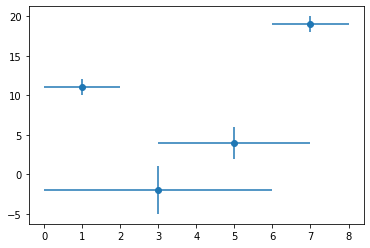

In [29]:
## Example of what I would like to have
import matplotlib.pyplot as plt
a = [1,3,5,7]
b = [11,-2,4,19]
plt.scatter(a,b)

c = [1,3,2,1]
plt.errorbar(a,b,yerr=c,xerr=c, linestyle="None")

plt.show()

### Finding the error: 
percent error = (model - obs)/obs * 100

In [30]:
# This is the error on the observations
err_ao = np.abs((np.nanmean(model_ao) -np.nanmean(obs_ao))/np.nanmean(obs_ao))
err_cs = np.abs((np.nanmean(model_cs) -np.nanmean(obs_cs))/np.nanmean(obs_cs))
err_bs = np.abs((np.nanmean(model_bs) -np.nanmean(obs_bs))/np.nanmean(obs_bs))
err_ca = np.abs((np.nanmean(model_ca) -np.nanmean(obs_ca))/np.nanmean(obs_ca))
err_bb = np.abs((np.nanmean(model_bb) -np.nanmean(obs_bb))/np.nanmean(obs_bb))
err_ess = np.abs((np.nanmean(model_ess) -np.nanmean(obs_ess))/np.nanmean(obs_ess))
err_ls = np.abs((np.nanmean(model_ls) -np.nanmean(obs_ls))/np.nanmean(obs_ls))
err_ns = np.abs((np.nanmean(model_ns) -np.nanmean(obs_ns))/np.nanmean(obs_ns))
err_bts = np.abs((np.nanmean(model_bts) -np.nanmean(obs_bts))/np.nanmean(obs_bts))
err_ks = np.abs((np.nanmean(model_ks) -np.nanmean(obs_ks))/np.nanmean(obs_ks))

# This is the error on the model
err_aom = np.abs((np.nanmean(obs_ao) -np.nanmean(model_ao))/np.nanmean(model_ao))
err_csm = np.abs((np.nanmean(obs_cs) -np.nanmean(model_cs))/np.nanmean(model_cs))
err_bsm = np.abs((np.nanmean(obs_bs) -np.nanmean(model_bs))/np.nanmean(model_bs))
err_cam = np.abs((np.nanmean(obs_ca) -np.nanmean(model_ca))/np.nanmean(model_ca))
err_bbm = np.abs((np.nanmean(obs_bb) -np.nanmean(model_bb))/np.nanmean(model_bb))
err_essm = np.abs((np.nanmean(obs_ess) -np.nanmean(model_ess))/np.nanmean(model_ess))
err_lsm = np.abs((np.nanmean(obs_ls) -np.nanmean(model_ls))/np.nanmean(model_ls))
err_nsm = np.abs((np.nanmean(obs_ns) -np.nanmean(model_ns))/np.nanmean(model_ns))
err_btsm = np.abs((np.nanmean(obs_bts) -np.nanmean(model_bts))/np.nanmean(model_bts))
err_ksm = np.abs((np.nanmean(obs_ks) -np.nanmean(model_ks))/np.nanmean(model_ks))

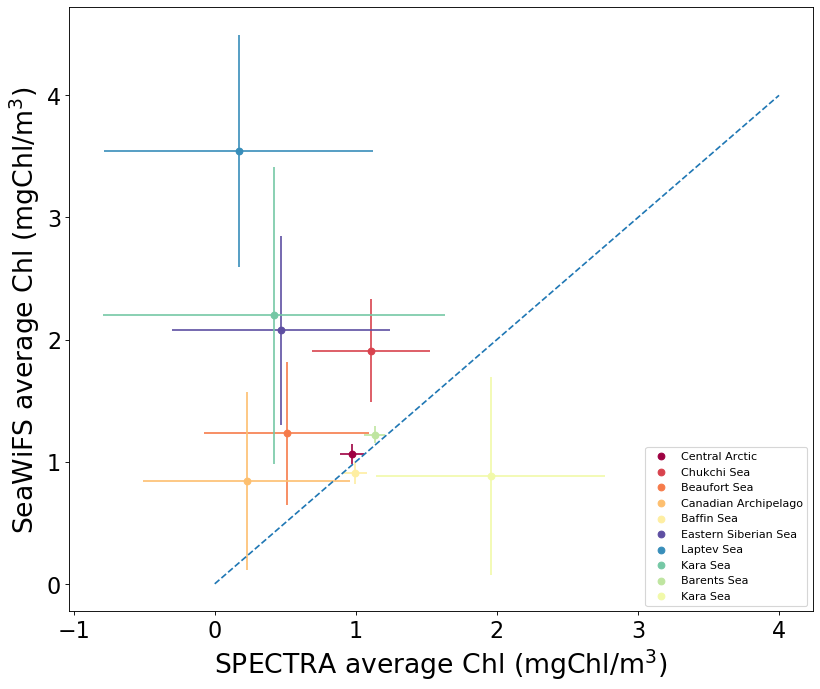

In [31]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(model_ao),np.nanmean(obs_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(model_ao),np.nanmean(obs_ao),yerr=err_ao,xerr=err_ao, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(model_cs),np.nanmean(obs_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(model_cs),np.nanmean(obs_cs),yerr=err_cs,xerr=err_cs, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(model_bs),np.nanmean(obs_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(model_bs),np.nanmean(obs_bs),yerr=err_bs,xerr=err_bs, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(model_ca),np.nanmean(obs_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(model_ca),np.nanmean(obs_ca),yerr=err_ca,xerr=err_ca, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(model_bb),np.nanmean(obs_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(model_bb),np.nanmean(obs_bb),yerr=err_bb,xerr=err_bb, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(model_ess),np.nanmean(obs_ess), color=cmap(9),label='Eastern Siberian Sea')
plt.errorbar(np.nanmean(model_ess),np.nanmean(obs_ess),yerr=err_ess,xerr=err_ess, color=cmap(9),linestyle="None")

plt.scatter(np.nanmean(model_ls),np.nanmean(obs_ls),color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(model_ls),np.nanmean(obs_ls),yerr=err_ls,xerr=err_ls, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(model_ks),np.nanmean(obs_ks), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(model_ks),np.nanmean(obs_ks),yerr=err_ns,xerr=err_ns, color=cmap(7),linestyle="None")

plt.scatter(np.nanmean(model_bts),np.nanmean(obs_bts), color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(model_bts),np.nanmean(obs_bts),yerr=err_bts,xerr=err_bts, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(model_ns),np.nanmean(obs_ns), color=cmap(5),label='Kara Sea')
plt.errorbar(np.nanmean(model_ns),np.nanmean(obs_ns),yerr=err_ks,xerr=err_ks, color=cmap(5),linestyle="None")

plt.plot([0,1,2,3,4], [0,1,2,3,4], '--')
plt.legend(loc='lower right')
plt.xlabel('SPECTRA average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.ylabel('SeaWiFS average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()

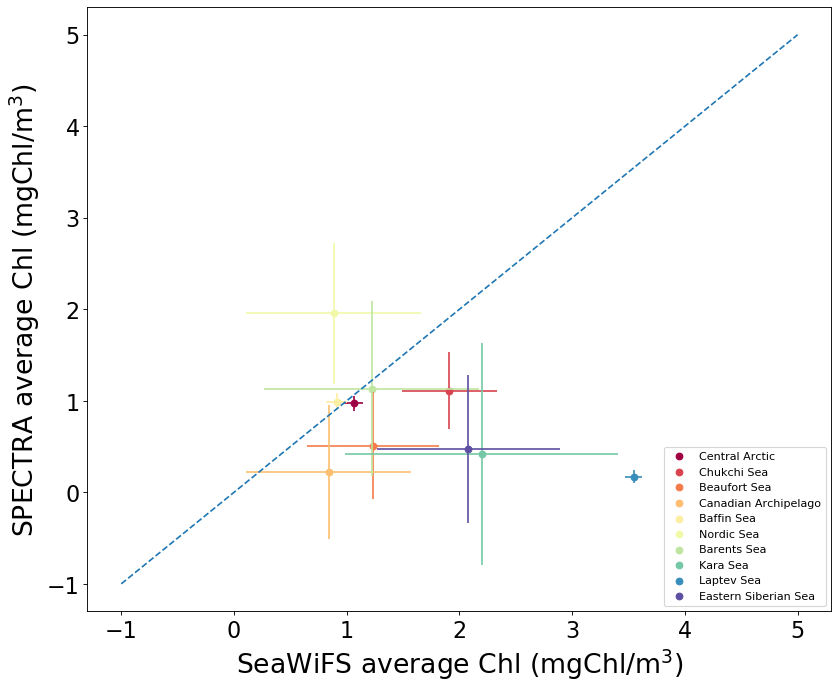

In [32]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(obs_ao),np.nanmean(model_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(obs_ao),np.nanmean(model_ao),yerr=err_ao,xerr=err_ao, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(obs_cs),np.nanmean(model_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(obs_cs),np.nanmean(model_cs),yerr=err_cs,xerr=err_cs, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(obs_bs),np.nanmean(model_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(obs_bs),np.nanmean(model_bs),yerr=err_bs,xerr=err_bs, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(obs_ca),np.nanmean(model_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(obs_ca),np.nanmean(model_ca),yerr=err_ca,xerr=err_ca, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(obs_bb),np.nanmean(model_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(obs_bb),np.nanmean(model_bb),yerr=err_bb,xerr=err_bb, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(obs_ns),np.nanmean(model_ns), color=cmap(5),label='Nordic Sea')
plt.errorbar(np.nanmean(obs_ns),np.nanmean(model_ns),yerr=err_ess,xerr=err_ess, color=cmap(5),linestyle="None")

plt.scatter(np.nanmean(obs_bts),np.nanmean(model_bts),color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(obs_bts),np.nanmean(model_bts),yerr=err_ls,xerr=err_ls, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(obs_ks),np.nanmean(model_ks), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(obs_ks),np.nanmean(model_ks),yerr=err_ns,xerr=err_ns, color=cmap(7),linestyle="None")

plt.scatter(np.nanmean(obs_ls),np.nanmean(model_ls), color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(obs_ls),np.nanmean(model_ls),yerr=err_bts,xerr=err_bts, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(obs_ess),np.nanmean(model_ess), color=cmap(9),label='Eastern Siberian Sea')
plt.errorbar(np.nanmean(obs_ess),np.nanmean(model_ess),yerr=err_ks,xerr=err_ks, color=cmap(9),linestyle="None")

plt.plot([-1,0,1,2,3,4,5], [-1,0,1,2,3,4,5], '--')

plt.legend(loc='lower right')
plt.ylabel('SPECTRA average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.xlabel('SeaWiFS average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_scatter_'+year+'year.png', dpi=600, bbox_inches='tight')

## This is setting different errors in the x than in the y axis by finding the fraction of error from the observed and from the error, as such :
error in the y = percent error = (obs - model)/model * 100
error in the x = percent error = (model - obs)/obs * 100

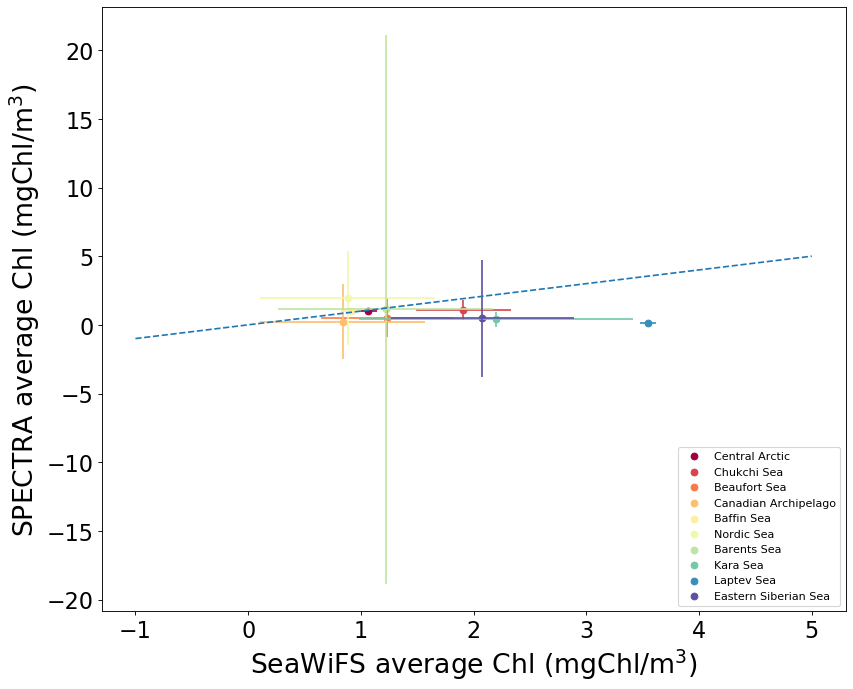

In [33]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(obs_ao),np.nanmean(model_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(obs_ao),np.nanmean(model_ao),yerr=err_aom,xerr=err_ao, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(obs_cs),np.nanmean(model_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(obs_cs),np.nanmean(model_cs),yerr=err_csm,xerr=err_cs, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(obs_bs),np.nanmean(model_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(obs_bs),np.nanmean(model_bs),yerr=err_bsm,xerr=err_bs, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(obs_ca),np.nanmean(model_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(obs_ca),np.nanmean(model_ca),yerr=err_cam,xerr=err_ca, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(obs_bb),np.nanmean(model_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(obs_bb),np.nanmean(model_bb),yerr=err_bbm,xerr=err_bb, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(obs_ns),np.nanmean(model_ns), color=cmap(5),label='Nordic Sea')
plt.errorbar(np.nanmean(obs_ns),np.nanmean(model_ns),yerr=err_essm,xerr=err_ess, color=cmap(5),linestyle="None")

plt.scatter(np.nanmean(obs_bts),np.nanmean(model_bts),color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(obs_bts),np.nanmean(model_bts),yerr=err_lsm,xerr=err_ls, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(obs_ks),np.nanmean(model_ks), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(obs_ks),np.nanmean(model_ks),yerr=err_nsm,xerr=err_ns, color=cmap(7),linestyle="None")

plt.scatter(np.nanmean(obs_ls),np.nanmean(model_ls), color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(obs_ls),np.nanmean(model_ls),yerr=err_btsm,xerr=err_bts, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(obs_ess),np.nanmean(model_ess), color=cmap(9),label='Eastern Siberian Sea')
plt.errorbar(np.nanmean(obs_ess),np.nanmean(model_ess),yerr=err_ksm,xerr=err_ks, color=cmap(9),linestyle="None")

plt.plot([-1,0,1,2,3,4,5], [-1,0,1,2,3,4,5], '--')

plt.legend(loc='lower right')
plt.ylabel('SPECTRA average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.xlabel('SeaWiFS average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()

## Now create one, but from the standrard devation from the mean in the x and in the y axis, I think this might be the correct way to do it. 

In [34]:
# This is the error on the observations
err_ao = np.nanstd(obs_ao)
err_cs = np.nanstd(obs_cs)
err_bs = np.nanstd(obs_bs)
err_ca = np.nanstd(obs_ca)
err_bb = np.nanstd(obs_bb)
err_ess = np.nanstd(obs_ess)
err_ls = np.nanstd(obs_ls)
err_ns = np.nanstd(obs_ns)
err_bts = np.nanstd(obs_bts)
err_ks = np.nanstd(obs_ks)

# This is the error on the model
err_aom = np.std(model_ao)
err_csm = np.std(model_cs)
err_bsm = np.std(model_bs)
err_cam = np.std(model_ca)
err_bbm = np.std(model_bb)
err_essm = np.std(model_ess)
err_lsm = np.std(model_ls)
err_nsm = np.std(model_ns)
err_btsm = np.std(model_bts)
err_ksm = np.std(model_ks)

In [35]:
np.nanstd(obs_ao)

0.60398096

In [36]:
err_aom

1.1449337

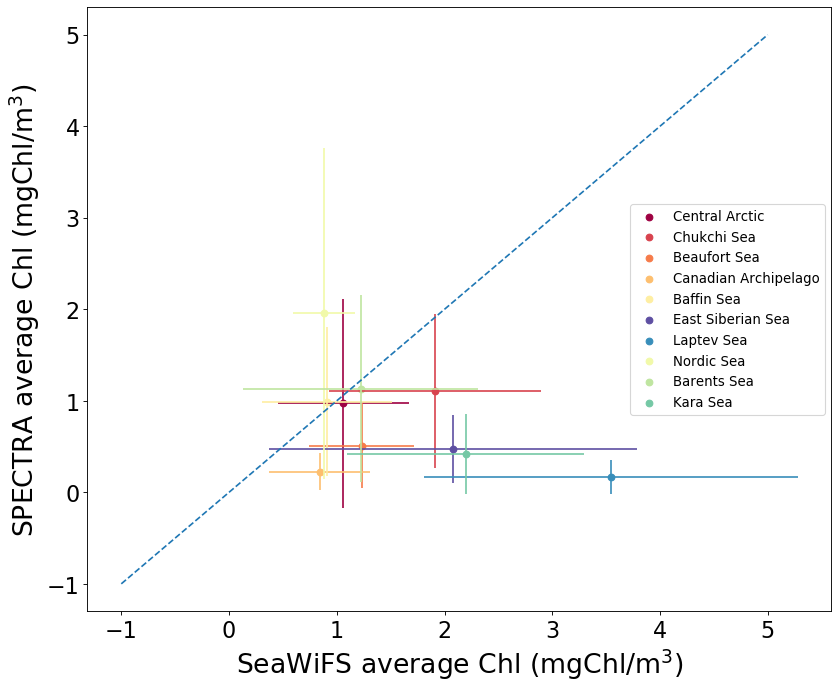

In [37]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(obs_ao),np.nanmean(model_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(obs_ao),np.nanmean(model_ao),yerr=err_aom,xerr=err_ao, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(obs_cs),np.nanmean(model_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(obs_cs),np.nanmean(model_cs),yerr=err_csm,xerr=err_cs, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(obs_bs),np.nanmean(model_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(obs_bs),np.nanmean(model_bs),yerr=err_bsm,xerr=err_bs, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(obs_ca),np.nanmean(model_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(obs_ca),np.nanmean(model_ca),yerr=err_cam,xerr=err_ca, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(obs_bb),np.nanmean(model_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(obs_bb),np.nanmean(model_bb),yerr=err_bbm,xerr=err_bb, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(obs_ess),np.nanmean(model_ess), color=cmap(9),label='East Siberian Sea')
plt.errorbar(np.nanmean(obs_ess),np.nanmean(model_ess),yerr=err_essm,xerr=err_ess, color=cmap(9),linestyle="None")

plt.scatter(np.nanmean(obs_ls),np.nanmean(model_ls),color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(obs_ls),np.nanmean(model_ls),yerr=err_lsm,xerr=err_ls, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(obs_ns),np.nanmean(model_ns), color=cmap(5),label='Nordic Sea')
plt.errorbar(np.nanmean(obs_ns),np.nanmean(model_ns),yerr=err_nsm,xerr=err_ns, color=cmap(5),linestyle="None")

plt.scatter(np.nanmean(obs_bts),np.nanmean(model_bts), color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(obs_bts),np.nanmean(model_bts),yerr=err_btsm,xerr=err_bts, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(obs_ks),np.nanmean(model_ks), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(obs_ks),np.nanmean(model_ks),yerr=err_ksm,xerr=err_ks, color=cmap(7),linestyle="None")

plt.plot([-1,0,1,2,3,4,5], [-1,0,1,2,3,4,5], '--')

plt.legend(loc='center right', fontsize=12)
plt.ylabel('SPECTRA average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.xlabel('SeaWiFS average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Chl_SPECTRA_SeaWIFS_scatter_'+year+'year.png', dpi=600, bbox_inches='tight')